In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode

This is to create the coco JSON files, only run this for setup

In [2]:
# run this only if setup is not complete 
import os
os.chdir('../lib')
import importlib, setup_coco_json, process_coco_json

importlib.reload(setup_coco_json)
importlib.reload(process_coco_json)

from setup_coco_json import setup_rgb, setup_grayscale, setup_rgbd
from process_coco_json import get_coco_rgb, get_coco_grayscale, get_coco_rgbd

os.chdir('../data')
setup_rgb('./invotive', coco_json_dir='./coco_json', per_train=70, per_val=15, per_test=15)
get_coco_rgb("./coco_json/rgb/")

Number of Images: 36

Number of Train Images: 25
Number of Val Images: 5
Number of Test Images: 6
Images have been saved to ./coco_json\rgb\train\images
Images have been saved to ./coco_json\rgb\train\masks\Tumor
Images have been saved to ./coco_json\rgb\val\images
Images have been saved to ./coco_json\rgb\val\masks\Tumor
Images have been saved to ./coco_json\rgb\test\images
Images have been saved to ./coco_json\rgb\test\masks\Tumor
Created 25 annotations for images in folder: ./coco_json/rgb/train/masks
Created 5 annotations for images in folder: ./coco_json/rgb/val/masks
Created 12 annotations for images in folder: ./coco_json/rgb/test/masks
Done creating COCO JSON annotations for all files


In [3]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, "../data/coco_json/rgb/train/images/train.json", "../data/coco_json/rgb/train/images/")
register_coco_instances("my_dataset_val", {}, "../data/coco_json/rgb/val/images/val.json", "../data/coco_json/rgb/val/images/")
register_coco_instances("my_dataset_test", {}, "../data/coco_json/rgb/test/images/test.json", "../data/coco_json/rgb/test/images/")

In [4]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

test_metadata = MetadataCatalog.get("my_dataset_test")
test_dataset_dicts = DatasetCatalog.get("my_dataset_test")

WARNING [09/25 22:06:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/25 22:06:03 d2.data.datasets.coco]: Loaded 25 images in COCO format from ../data/coco_json/rgb/train/images/train.json
WARNING [09/25 22:06:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/25 22:06:03 d2.data.datasets.coco]: Loaded 5 images in COCO format from ../data/coco_json/rgb/val/images/val.json
WARNING [09/25 22:06:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/25 22:06:03 d2.data.datasets.coco]: Loaded 6 images in COCO format from ../data/coco_json/rgb/test/images/test.json


In [5]:
for d in random.sample(val_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

TypeError: 'NoneType' object is not subscriptable

In [6]:
from detectron2.engine import DefaultTrainer

# this config was adapted from the detectron2 documentation for our purposes 

cfg = get_cfg()
# make sure to set output directory
cfg.OUTPUT_DIR = "../models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_val",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 2  
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 2000    
cfg.SOLVER.STEPS = []       
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False) 

[09/25 22:06:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

In [8]:
trainer.train()

[09/25 22:06:51 d2.engine.train_loop]: Starting training from iteration 0
ERROR [09/25 22:06:51 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "c:\Users\abir\anaconda3\envs\dl-tumor\Lib\site-packages\detectron2\engine\train_loop.py", line 155, in train
    self.run_step()
  File "c:\Users\abir\anaconda3\envs\dl-tumor\Lib\site-packages\detectron2\engine\defaults.py", line 530, in run_step
    self._trainer.run_step()
  File "c:\Users\abir\anaconda3\envs\dl-tumor\Lib\site-packages\detectron2\engine\train_loop.py", line 297, in run_step
    data = next(self._data_loader_iter)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
StopIteration
[09/25 22:06:51 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


AttributeError: 'EvalHook' object has no attribute '_func'

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[07/26 18:15:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./models/Detectron2_Models/model_final.pth ...


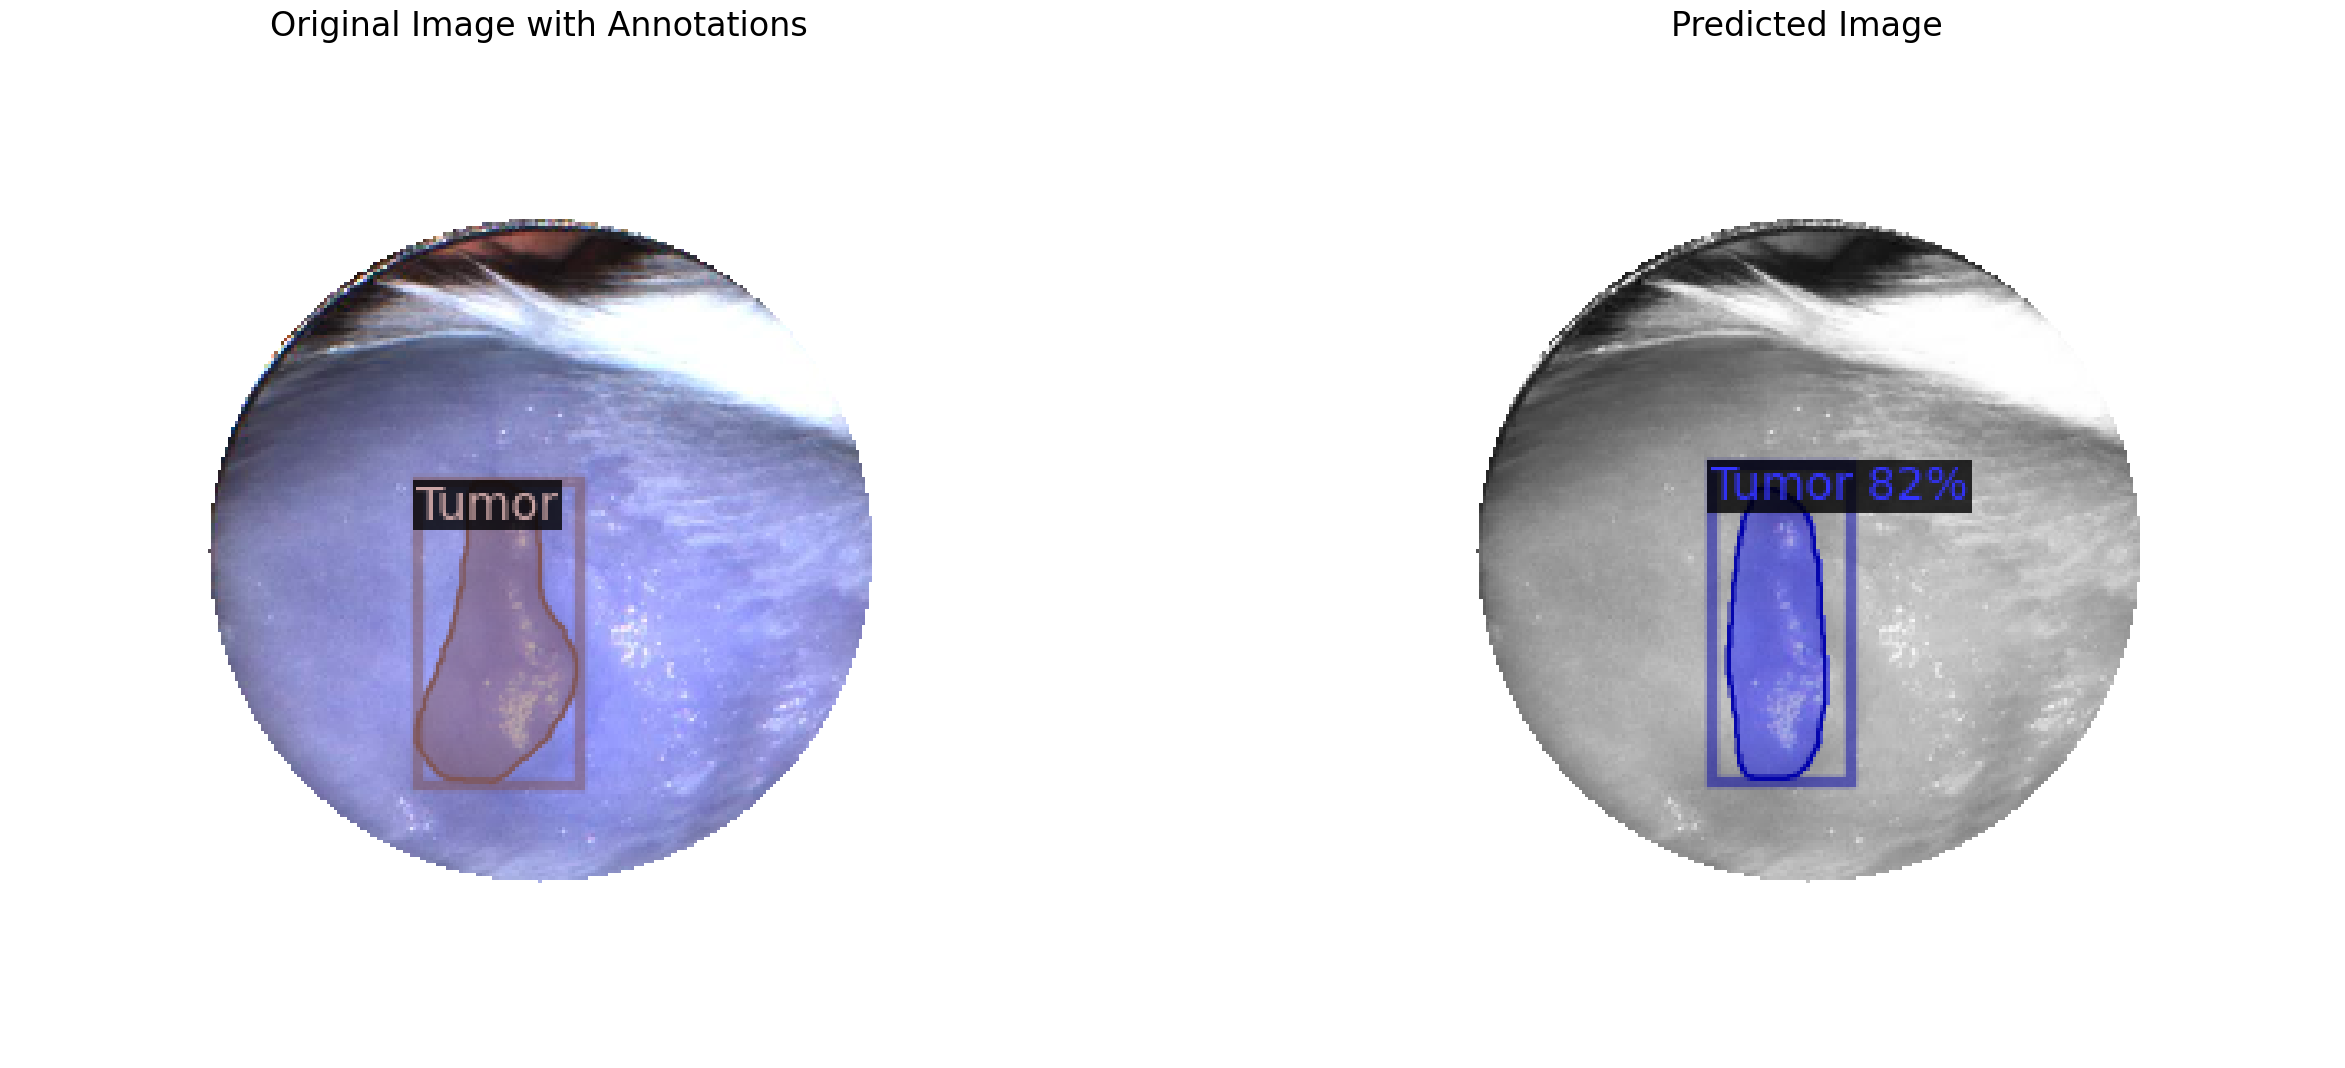

In [12]:


# Function to display the original image with annotations and the predicted image
def display_original_and_prediction_with_annotations(val_dataset_dicts, predictor, val_metadata):
    for d in random.sample(val_dataset_dicts, 1):  # Select number of images for display
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        
        # Create a visualizer object for the original image with annotations
        v_gt = Visualizer(im[:, :, ::-1],
                          metadata=val_metadata,
                          scale=0.5
        )
        out_gt = v_gt.draw_dataset_dict(d)
        
        # Create a visualizer object for the predicted image
        v_pred = Visualizer(im[:, :, ::-1],
                            metadata=val_metadata,
                            scale=0.5,
                            instance_mode=ColorMode.IMAGE_BW  # Remove the colors of unsegmented pixels
        )
        out_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        # Set up subplots
        fig, ax = plt.subplots(1, 2, figsize=(30, 30))
        
        # Display the original image with annotations
        ax[0].imshow(out_gt.get_image()[:, :, ::-1])
        ax[0].set_title('Original Image with Annotations', fontsize=24)
        
        # Display the predicted image
        ax[1].imshow(out_pred.get_image()[:, :, ::-1])
        ax[1].set_title('Predicted Image', fontsize=24)

        for a in ax:
            a.axis("off")
        
        plt.show()

# Example usage
display_original_and_prediction_with_annotations(test_dataset_dicts, predictor, test_metadata)


In [15]:
def save_all_images(val_dataset_dicts, predictor, val_metadata, output_dir):
    
    #create image path if it doesnt exist 
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, d in enumerate(val_dataset_dicts):

        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        
        v_gt = Visualizer(im[:, :, ::-1], metadata=val_metadata, scale=0.5)
        out_gt = v_gt.draw_dataset_dict(d)
        
        v_pred = Visualizer(im[:, :, ::-1], metadata=val_metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
        out_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        fig, ax = plt.subplots(1, 2, figsize=(30, 30))

        ax[0].imshow(out_gt.get_image()[:, :, ::-1])
        ax[0].set_title('Image with Original Annotations', fontsize=24)
        ax[0].axis('off')
        
        # Display the predicted image
        ax[1].imshow(out_pred.get_image()[:, :, ::-1])
        ax[1].set_title('Images with Annotations produced by the model', fontsize=24)
        ax[1].axis('off')
        
        fig.savefig(os.path.join(output_dir, f"image_{i}.png"), bbox_inches="tight")
        plt.close(fig) 

In [16]:
save_all_images(test_dataset_dicts, predictor, test_metadata, './detectron2/images_rgb')